# DTSA 5511: GAN Project

## Project Overview

For this project, I will be competiting in the "I'm Something of a Painter Myself" competition from Kaggle. The objective will be to create a deep learning model that can be trained on images of paintings and then create new images of paintings on its own. The trained model will take ordinary pictures and turn them into "Monet" style paintings. My initial plan is to construct a GAN model using layers from the Keras library, and make adjustments as time permits.

In [16]:
#Importing Libraries & Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow.keras import layers, Model
import os
import zipfile
import cv2

## Monet Images Data Set

The data that is to be used in this competition can be found from Kaggle (linked below). Within the data, there are 300 images of Monet paintings, and there are over 7,000 orginary images. All images are sized 256x256 in various formats (JPEG & TFRecord). 

https://www.kaggle.com/competitions/gan-getting-started/data

## Data Cleaning

I wanted to be sure to address the process of data cleaning; however, it largely does not apply in this project. All images are formatted in the same manner (256x256), and the Monet paintings and the photos exist in separate folders. I did not take any steps to "clean" data, and my first step was to load images into datasets (monet_dataset & photo_dataset) using the Keras image_dataset_from_directory function.

In [4]:
#Loading in Processed Images
def load_images(dir):
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
        dir,
        image_size=(256, 256),
        batch_size=1,
        label_mode=None
    )
    return dataset.map(lambda x: (x - 128) / 128).repeat()

monet_dataset = load_images('/Users/jschlangen/Desktop/gan-getting-started/monet_jpg')
photo_dataset = load_images('/Users/jschlangen/Desktop/gan-getting-started/photo_jpg')

Found 300 files.
Found 7038 files.


## Exploratory Data Analysis

As for the exploratoty data anlysis, this was a fairly straightforward process. All of the data for this project are images, so it is difficult to generate insight and understanding from it.

With that said, I provided a glimpse of the processed images so that we can better understand the data that will be fed into the model. I also included 5 sample images of the "Monet" style paintings so that we can visualize these.

In [11]:
#Provide View of Processed Images
next(iter(monet_dataset))

<tf.Tensor: shape=(1, 256, 256, 3), dtype=float32, numpy=
array([[[[ 0.0703125, -0.046875 , -0.3515625],
         [ 0.171875 ,  0.0546875, -0.25     ],
         [ 0.1875   ,  0.078125 , -0.2265625],
         ...,
         [ 0.28125  ,  0.1328125, -0.1953125],
         [ 0.2734375,  0.125    , -0.1875   ],
         [ 0.28125  ,  0.1328125, -0.1796875]],

        [[ 0.0546875, -0.0625   , -0.3671875],
         [ 0.1171875,  0.       , -0.3046875],
         [ 0.1171875,  0.0078125, -0.296875 ],
         ...,
         [ 0.2265625,  0.078125 , -0.25     ],
         [ 0.234375 ,  0.0859375, -0.2265625],
         [ 0.2578125,  0.109375 , -0.203125 ]],

        [[ 0.0546875, -0.0625   , -0.3671875],
         [ 0.0546875, -0.0625   , -0.3671875],
         [ 0.046875 , -0.0625   , -0.3671875],
         ...,
         [ 0.1640625,  0.015625 , -0.3203125],
         [ 0.1875   ,  0.0390625, -0.2890625],
         [ 0.234375 ,  0.0859375, -0.2421875]],

        ...,

        [[-0.1015625, -0.2109375, 

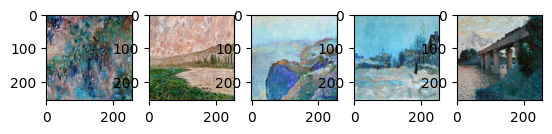

In [15]:
#Show 5 Sample Images
names = ['0a5075d42a.jpg', '0bd913dbc7.jpg', '000c1e3bff.jpg', '0e3b3292da.jpg', '1a127acf4d.jpg']

fig = plt.figure()

for i in range(len(names)):
    img = cv2.imread('/Users/jschlangen/Desktop/gan-getting-started/monet_jpg/' + names[i])
    ax = fig.add_subplot(1, 5, i+1)
    ax.imshow(img)

## Model Architecture

As mentioned above, I will be constructing a GAN model using the Keras library. Similar to what was demonstrated in the lecture, this model includes an input layer, 3 hidden layers, and an output layer. This is a great starting place, and for the scope of the project, this model will suffice.

Once the model was built and saved (my_generator), I trained it using the "Monet" style paintings and the ordinary images. The images were input into my created model, leading to a reduction in loss. I used the Tensorflow GradientTape function and the Adam optimizer for gradient descent.

In [4]:
#Construct Image Generator
def build_generator():
    inputs = layers.Input(shape=(256, 256, 3))
    x = layers.Conv2D(64, kernel_size=7, padding='same', activation='relu')(inputs)
    x = layers.Conv2D(128, kernel_size=3, strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding='same', activation='relu')(x)
    outputs = layers.Conv2D(3, kernel_size=7, padding='same', activation='tanh')(x)
    return Model(inputs, outputs)

my_generator = build_generator()
optimizer = tf.keras.optimizers.Adam()

In [5]:
#Contruct and Train GAN Model
@tf.function
def train(x, y):
    with tf.GradientTape() as tape:
        yp = my_generator(x)
        loss = tf.reduce_mean(tf.square(yp - y))

    grads = tape.gradient(loss, my_generator.trainable_variables)

    optimizer.apply_gradients(zip(grads, my_generator.trainable_variables))

epochs = 5
steps = 350
for epoch in range(epochs):
    for step in range(steps):
        x = next(iter(photo_dataset))
        y = next(iter(monet_dataset))
        train(x, y)

## Results & Analysis

Once the model was trained, I generated images using the ordinary photos as an input. These images were saved in the images.zip file and uploaded to the Kaggle competition.

As far as results go, I was quite pleased with my score and position in the leaderboard. I received a score of 180, which put me in the top 70 positions in the leaderboard. Overall scores range from 40 - 416; therefore, I am quite pleased with my score of 180.

In [ ]:
#Generate Images
output_loc = 'generated_images'
os.makedirs(output_loc, exist_ok=True)

count = 0
max_images = 10000

for x in photo_dataset:
    while count < max_images:
        image = my_generator(x)[0]
        image = ((image.numpy() + 1) * 255 / 2).astype(int)
        
        filename = os.path.join(output_loc, 'generated_' + str(count) + '.jpg')
        tf.keras.preprocessing.image.save_img(filename, image)
        
        count += 1

In [ ]:
#Create .zip file for Kaggle Submission
with zipfile.ZipFile('images.zip', 'w') as zipf:
    for root, _, files in os.walk(output_loc):
        for file in files:
            zipf.write(os.path.join(root, file), file)

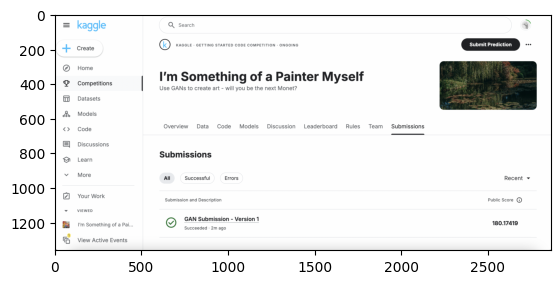

In [17]:
img = mpimg.imread('/Users/jschlangen/Desktop/GAN Submission.png')

plt.imshow(img)
plt.show()

## Conclusion

Overall, I am very happy with the results of my project and this competition. The GAN model that was built proved to be effective in generating "Monet" style painting images. My score of 180 and position on the leaderboard in the top 70 has me feeling confident and pleased. With that said, it is clear that the model could be improved to generating stronger paintings. In future iterations, I would look to further tune hyperparameters and adjust image processing techniques for better results.